<a href="https://colab.research.google.com/github/monu322/CE888/blob/main/Assg2/EmotionDetection/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyLDAvis

In [3]:
import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import spacy
import pandas as pd
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#importing emotion dataset

tweets_emotion=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt', header=None)
print('Training tweets', tweets_emotion.shape)

tweets_emotion_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt', header=None)
print('Training labels', tweets_emotion_labels.shape)

tweets_emotion_test=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt', header=None)
print('Test tweets',tweets_emotion_test.shape)

tweets_emotion_test_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt', header=None)
print('Test labels',tweets_emotion_test_labels.shape)

Training tweets (3257, 1)
Training labels (3257, 1)
Test tweets (1421, 1)
Test labels (1421, 1)


In [6]:
tweets_emotion.columns = ['text']
tweets_emotion_test.columns = ['text']

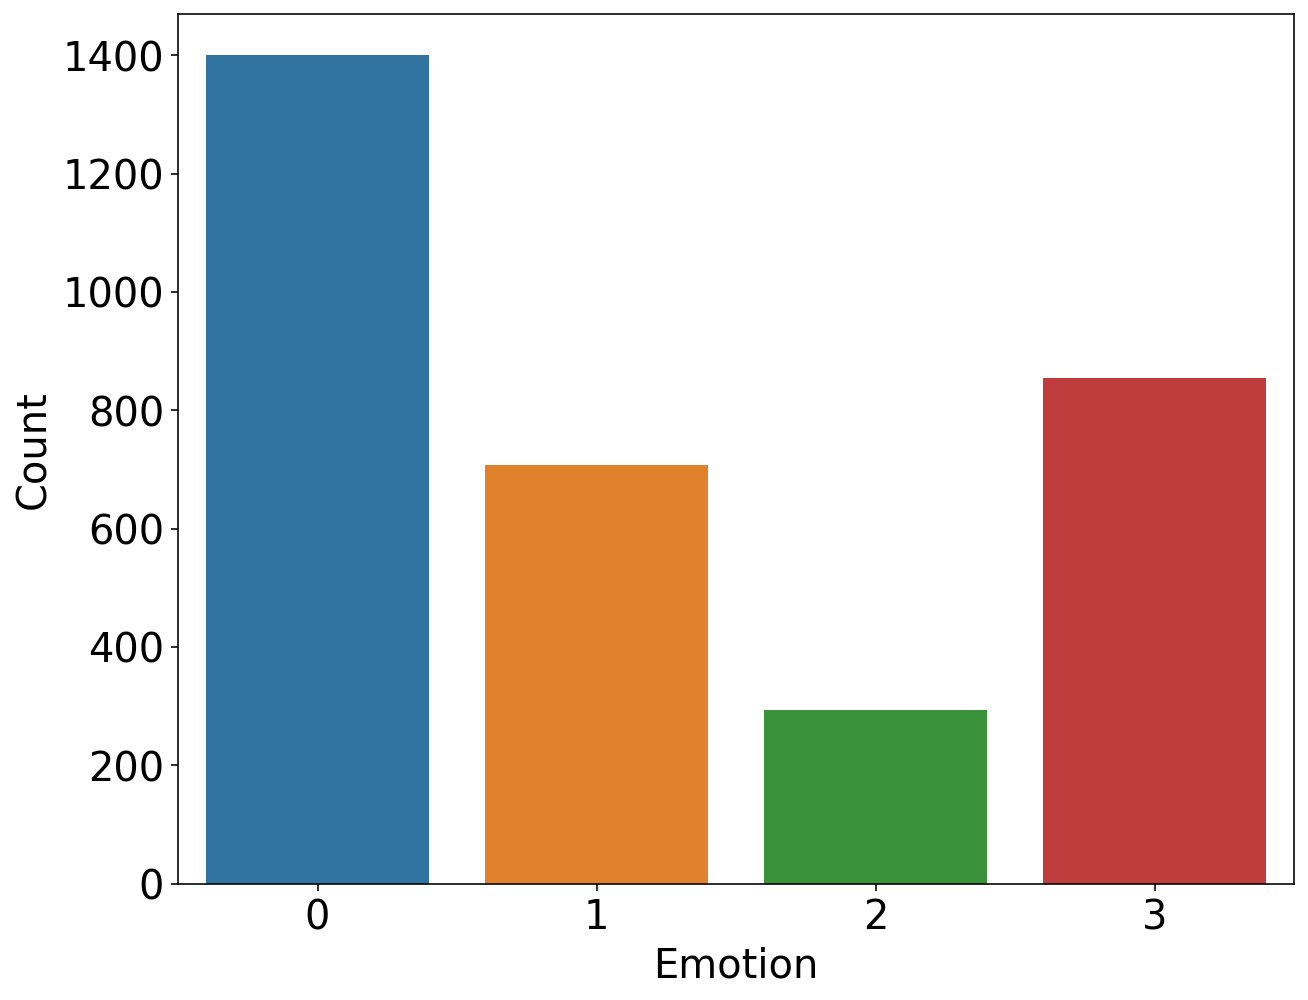

In [9]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot(0, data = tweets_emotion_labels)
plt.ylabel('Count')
plt.xlabel('Emotion');

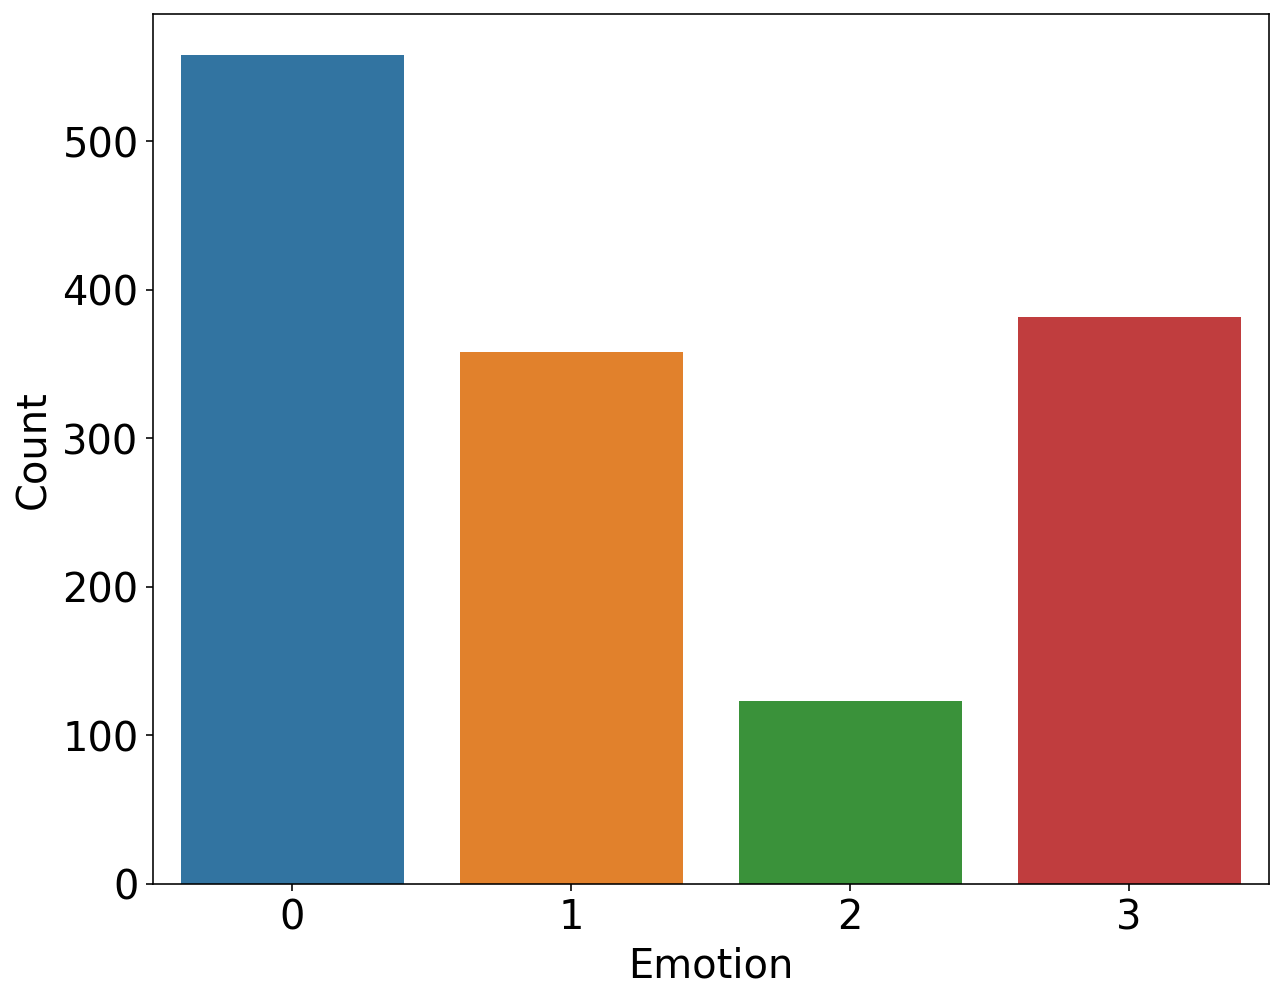

In [11]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot(0, data = tweets_emotion_test_labels)
plt.ylabel('Count')
plt.xlabel('Emotion');

In [14]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


nlp = spacy.load('en', disable=['parser', 'ner'])

def strip_newline(series):
    return [review.replace('\n','') for review in series]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    
    df['text'] = strip_newline(df.text)
    words = list(sent_to_words(df.text))
    words = remove_stopwords(words)
    bigram = bigrams(words)
    bigram = [bigram[review] for review in words]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram

In [15]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(tweets_emotion)

In [19]:
import logging
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=20,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)

In [20]:
coherence_model_lda = CoherenceModel(model=lda_train4, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.5707943868725098

In [21]:
lda_train4.print_topics(40,num_words=15)[:40]

[(0,
  '0.164*"know" + 0.084*"let" + 0.074*"want" + 0.046*"away" + 0.041*"show" + 0.034*"friends" + 0.032*"around" + 0.025*"real" + 0.023*"comes" + 0.023*"hillary" + 0.022*"side" + 0.021*"yet" + 0.020*"class" + 0.020*"thinking" + 0.019*"offend"'),
 (1,
  '0.083*"horrible" + 0.078*"bad" + 0.067*"could" + 0.058*"serious" + 0.043*"house" + 0.041*"shit" + 0.041*"nervous" + 0.040*"literally" + 0.037*"get" + 0.037*"feeling" + 0.036*"two" + 0.036*"hell" + 0.029*"took" + 0.027*"care" + 0.026*"watched"'),
 (2,
  '0.074*"man" + 0.072*"fuming" + 0.060*"tell" + 0.060*"well" + 0.049*"stop" + 0.040*"broadcast" + 0.039*"live_ly" + 0.039*"musically" + 0.039*"watch_amazing" + 0.033*"lively" + 0.031*"funny" + 0.029*"outside" + 0.027*"getting" + 0.024*"dont" + 0.023*"contact"'),
 (3,
  '0.135*"day" + 0.086*"fucking" + 0.081*"im" + 0.061*"someone" + 0.057*"depressing" + 0.053*"much" + 0.037*"one" + 0.028*"thank" + 0.026*"yeah" + 0.025*"died" + 0.024*"tired" + 0.021*"fiery" + 0.020*"seeing" + 0.018*"think"

In [30]:
train_vecs = []

for i in range(len(tweets_emotion)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    train_vecs.append(topic_vec)

print("Document topic matrix of 1st review: ", train_vecs[0])

Document topic matrix of 1st review:  [0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.675, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.175, 0.008333334, 0.008333334]
3257


In [31]:
import warnings
warnings.filterwarnings('ignore')

X = np.array(train_vecs)
y = np.array(tweets_emotion_labels)

kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    #Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='weighted'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SGD Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')


Logistic Regression Val f1: 0.336 +- 0.013
Logisitic Regression SGD Val f1: 0.339 +- 0.017
SGD Huber Val f1: 0.222 +- 0.129


In [32]:
test_corpus4, test_id2word4, bigram_test4 = get_corpus(tweets_emotion_test)

In [33]:
test_vecs = []

for i in range(len(tweets_emotion_test)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    test_vecs.append(topic_vec)

print("Document topic matrix of 1st review: ", test_vecs[0])

Document topic matrix of 1st review:  [0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.675, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.008333334, 0.175, 0.008333334, 0.008333334]


In [38]:
from sklearn import svm

X_test = np.array(test_vecs)
y_test = np.array(tweets_emotion_test_labels)

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X, y)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [37]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.23147912999371975
